# Evolution including Virus Family hybrid Clustering based on artificially mutated K-mers

## Milestones

- [x] HDBSCAN github errors
    - need to find version without problems
    - if now finding one revert back to MA version
    - revert back to Masterthesis and update jupyter lab, git and ressource
- [x] better inclusion of R, N, ... in the kmer
    - implemented, maybe need adjustment by value
    - if frature of missing higher than threshold garbage
    - if not fill missing by possible constellations
- [x] evolution on reading frame
    - difficult with amino conservation ORF tracker necessary
        - e.g. BLOSUM etc.
    - nucleotide exchange values used now, instead of amino exchange
        - usage of Kimura's two-parameter model
        - alpha and beta of user choice
- [ ] stable parameters 
    - best would be algorithmic solution here
        - number of clusters
            - neighbors -> distance matrix -> kneedle algorithm -> epsilon
        - sample number
            - cluster number extraction algorithms -> sample 
    - alpha value (A -> G, C -> T)
    - beta value (...)
    - for more flexibility algorithmis solution was postponed to a later release

- [x] global local hybrid clustering (GLHC)
    - idea war rejected first due to the necessary nxn space in worst case
    - maybe precalculation reinclude into clustering in the first place useful at some point
        - precalculation: nxn
        - no precalculation: nxk 
        - could be usefull in the future to change to precalculation
        - necessary for this step is the stepwise calculation of the precalc matrix
            - d(acc1, acc2), d(acc1, acc3), d(acc1, acc4), ..., d(acc1, accn)
            - d(acc2, ....) find a way to calculate the rest based on the first line
    - all point cluster distance (apcd) instead of centroids
    - centroids -> single linkage(centroids)
        - difficulat to validate the quality of this method
        - used method at the moment cluster -> centroids -> alignment -> nexus
- [ ] k-mer implementation by taking only existing values into account
    - copy and update the old code from the project
    - changes in the k-mer calculation postponed!
- [x] R variable userfriedly pipeline implementation 
- [x] R ggtree + heatmap implementation
- [x] R nexus implementation
    - still some flaws to eliminate
    - color full clades of clusters difficult due to strong limitations of the phangorn package
    - tiplabel and tippoint used as subtype clarification - OK
    - nearly all flaws fixed
- [ ] R test pipeline with other viruses to find remaining errors
- [x] R build conda yaml with all packages and no errors
- [x] R implement splittree into R by msa -> nexus conversion !!!!

## Python

### Packages

#### Clustering

In [1]:
import numpy as np
import pandas as pd
import itertools as it
from Bio import SeqIO
#from Bio.Seq import Seq
#import math
import re
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
import multiprocessing as mp
#import umap
import hdbscan
import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
from tqdm import tqdm
from kneed import KneeLocator
import scipy.signal as signal

#### Alignment

In [2]:
from io import StringIO
from Bio import AlignIO
from Bio.Align.Applications import MafftCommandline
#from IPython.display import display
from Bio.Phylo.Applications import RaxmlCommandline
import glob
import os

#### Graphics

In [52]:
import plotly.express as px

### Classes and Definitions

#### Clustering

In [3]:
class Vectors(object):
    
    def __init__(self, k = 7, identifier = 0, split = None, quality = {'':0}, variable = 2, state = 1.0, alpha = 0.0, beta = 0.0, init = 0.0, procs = 4, preprocess = True):
    
        self.k = k
        self.quality = quality
        self.identifier = identifier
        self.split = split
        self.variable = variable
        self.nucleotides = ['A', 'C', 'G', 'T']
        self.purines = ['A', 'G']
        self.pyrines = ['C', 'T']
        self.exotics = ['R', 'Y', 'W', 'S', 'M', 'K', 'B', 'H', 'D', 'V', 'N']
#        self.substit = dict.fromkeys(map(ord, self.nucleotides), None)
#        self.exist = dict.fromkeys(map(''.join, it.product(self.nucleotides, repeat = self.k)), init)        
        self.state = state
        self.init = init
        self.procs = procs
        self.alpha = alpha
        self.beta = beta
        self.preprocess = preprocess
        self.exchange = {
            'A': ['A'],
            'C': ['C'],
            'G': ['G'],
            'T': ['T'],
            'R': ['A', 'G'],
            'Y': ['C', 'T'],
            'W': ['A', 'T'],
            'S': ['C', 'G'],
            'M': ['A', 'C'],
            'K': ['G', 'T'],
            'B': ['G', 'C', 'T'],
            'H': ['A', 'C', 'T'],
            'D': ['A', 'G', 'T'],
            'V': ['A', 'C', 'G'],
            'N': ['A', 'C', 'G', 'T'],
        }
        self.kimura = {}
        for nuc in self.nucleotides:
            self.kimura[nuc] = {}
            if self.alpha != 0.0: 
                a = self.purines if nuc in self.purines else self.pyrines
                pos = 0 if a.index(nuc) != 0 else 1
                self.kimura[nuc][a[pos]] = self.alpha
            if self.beta != 0.0:
                b = self.purines if nuc not in self.purines else self.pyrines
                self.kimura[nuc][b[0]] = self.beta
                self.kimura[nuc][b[1]] = self.beta
    
    def countRows(self, infile):
        
        index = []
        record = SeqIO.index(infile, "fasta", key_function = lambda entry: entry.split(self.split)[self.identifier] if type(self.identifier) == int else re.search('.*' + self.identifier + '([^|]+).*', entry)[1])
        for accession in record.keys():
            
            entry = record[accession]
            header = entry.description.split(self.split)
            sequence = str(entry.seq)
            #missing = len(sequence.translate(self.substit))
            #fracture = float(len(sequence)/missing) if missing else 0 
            missing = re.findall('['+''.join(self.exotics)+']+', sequence)
            
            try:
                if all([re.match(i, header[self.quality[i]], re.IGNORECASE) for i in self.quality]) == True and (0 if not missing else len(max(missing, key=len))) <= self.variable:
                #if all([re.match(i, header[self.quality[i]], re.IGNORECASE) for i in self.quality]) == True and fracture <= 0.9:
                    index.append(accession)
            except:
                pass
        
        return(index, record)
    
    def preprocessKmer(self, sequence):
        
        exist = []
        for i in range(len(sequence) - self.k + 1):
            kmer = sequence[i:i+self.k]
            main = list(map(''.join, it.product(*[self.exchange.get(j) for j in kmer])))

            for sub in main:
                exist.append(sub)
                #if self.kimura:
                #    for l, nuc in enumerate(sub):
                #        for mut in self.kimura[nuc].keys():
                #            mutation = sub[:l] + mut + sub[l+1:]
                            #self.exist[sub] = 0
                #            exist.append(mutation)

        return(exist)
    
    def calculateKmer(self, data):
        
        temporary, sequence = data
        
        for i in range(len(sequence) - self.k + 1):
            kmer = sequence[i:i+self.k]
            main = list(map(''.join, it.product(*[self.exchange.get(j) for j in kmer])))

            for sub in main:
                temporary[sub] += self.state/len(main)
                if self.kimura:
                    for l, nuc in enumerate(sub):
                        for mut in self.kimura[nuc].keys():
                            mutation = sub[:l] + mut + sub[l+1:]
                            if mutation in temporary:
                                temporary[mutation] += self.kimura[nuc][mut]

        vector = np.fromiter(temporary.values(), dtype = 'float32', count = len(temporary.keys()))/sum(temporary.values())
        temporary.clear()
        return(vector)
        
    def calculateFrequence(self, infile):
        
        index, record = self.countRows(infile)
        #matrix = np.empty((len(index), self.col, ),dtype = 'float32')
        
        if self.preprocess == True:
            with mp.Pool(self.procs) as pool:
                preprocessor = tqdm(pool.imap(self.preprocessKmer, map(lambda m: str(record[m].seq), index)), total = len(index), desc="Preprocessing")
                exist = dict(sorted(dict.fromkeys(it.chain.from_iterable(preprocessor), self.init).items()))

        else:
            exist = dict.fromkeys(map(''.join, it.product(self.nucleotides, repeat = self.k)), self.init)    
                
        shared = it.repeat(exist,len(index))
        
        with mp.Pool(self.procs) as pool:
            calculator = tqdm(pool.imap(self.calculateKmer, zip(shared, map(lambda m: str(record[m].seq), index))), total = len(index), desc="Calculation")
            matrix = np.fromiter(it.chain.from_iterable(calculator), dtype = 'float32', count = len(exist.keys()) * len(index))
            matrix.shape = len(index), len(exist.keys())
            #for pos, vector in enumerate(calculator):
            #    matrix[pos] = vector
                
        return(index, matrix)

- execution can still be faster ca. 15-20min for segment 4 is still slow, lul now its 2 at max
    - inclusion of mutation increased the runtime by factor 5-10, nvm multipressing easy
    - multiprocessing difficult to implement (dicts, fast calculation of single instances high overhang)
- all mutations and all unkown kmers (including e.g. Ns) are counted with state or respective alpha beta
    - maybe split value by their number

In [4]:
def knee_location(linkage, t=50, p=0.5, sig=20):

    numpy_linkage = linkage.drop(columns=['parent']).to_numpy()
    
    y = numpy_linkage[:, 2][::-1]
    x = np.arange(1, len(y) + 1)

    kn = KneeLocator(np.log(x), y,
        curve='convex',
        direction='decreasing',
        interp_method="interp1d",
        #online=True,
        #S = 1.0,
    )

    #kn.plot_knee_normalized()
    #plt.savefig('difference.png')

    a = pd.DataFrame(zip(x, y, kn.x_difference, kn.y_difference), columns = ['x', 'y', 'x_diff', 'y_diff'])
    #b = kn.y_difference

    window = signal.general_gaussian(t+1, p=p, sig=sig)
    filtered = signal.fftconvolve(window, kn.y_difference)
    filtered = (np.average(kn.y_difference) / np.average(filtered)) * filtered
    filtered = np.roll(filtered, -25)

    # determine the indices of the local maxima
    max_ind = signal.argrelextrema(filtered[:-t], np.greater)

    a['gauss'] = filtered[:-t]

    #plt.subplot(1, 2, 1)
    #plt.plot(kn.x_difference, kn.y_difference, color='r')
    #plt.subplot(1, 2, 2)
    #plt.plot(kn.x_difference, filtered[:-t], color='r')
    #plt.tight_layout()
    #plt.savefig('gaussian.png')

    # get the actual values using these indices
    r = kn.y_difference[max_ind]  # array([5, 3, 6])
    
    return(a, r)

In [5]:
def Cluster(linkage, minclust, numclust, max_iter = 500):

    x = 0.0
    y = 1.0
    z = 0.0
    cluster = linkage.get_clusters(cut_distance = x, min_cluster_size = minclust)
    n = cluster.max().item()

    while n != numclust:

        if n < numclust and n != -1:
            z = x
            x = x - y
            y = y * 0.1

        else:
            z = x
            x = x + y

        cluster = linkage.get_clusters(cut_distance = x, min_cluster_size = minclust)
        n = cluster.max().item()
        
        if x != 0.0 and n == -1:
            cluster = linkage.get_clusters(cut_distance = z, min_cluster_size = minclust)
            n = cluster.max().item()
            print(f'Error: Value not reachable. Using {n} cluster.')
            break
            
        if max_iter == 0:
            cluster = linkage.get_clusters(cut_distance = x, min_cluster_size = minclust)
            n = cluster.max().item()
            print(f'Warning: Max iteration reached. Using {n} cluster.')
            break
            
        max_iter = max_iter - 1
        
    return(cluster, n)

In [6]:
def workerCentroid(subtuple):
    
    subl2, i = subtuple
    indexdist = subl2.index.tolist()
    calcdist = map(lambda x: ssd.cdist([x[1]], subl2, 'euclidean').mean(), subl2.iterrows())
    framedist = pd.DataFrame(np.fromiter(calcdist, dtype = 'float32', count = len(subl2)), index = indexdist)
    return(framedist.idxmin().item(), i)

In [7]:
def Centroid(framecluster, framel2):
    
    groups = framecluster.query('cluster != -1').groupby('cluster').groups
    
    with mp.Pool(procs) as pool:
        result = pool.imap(workerCentroid, map(lambda match: (framel2.loc[groups[match]], match), groups.keys()))
        centroid = pd.DataFrame(result, columns = ['accession', 'cluster']).set_index('accession')
        
    return(centroid)

In [8]:
def Linkage(framecentroid, framel2, procs):
    
    subl2 = framel2.loc[framecentroid.index.tolist()]
    distance = ssd.cdist(subl2, subl2, 'euclidean')
    linkage = hierarchy.linkage(distance, method = 'single', metric = 'euclidean')
    
    return(linkage, distance)

In [9]:
def fillGaps(frame):
    
    array = frame.unique()
    array = array[array != '']
    if len(array) == 1:
        frame.replace('', array[0], inplace = True)
        frame.fillna(array[0], inplace = True)
    else:
        frame.replace('', 'na', inplace = True)
        frame.fillna('na', inplace = True)
        #changed to mixed from NA good decision?
        
    return(frame)

In [10]:
def curateFASTA(infile, split, identifier = 0, columns = {'':1}):
    
    meta = {ident:{} for ident in columns.keys()}
    
    for entry in SeqIO.parse(infile,'fasta'):
    
        header = entry.description.split(split)

        accession = header[identifier] if type(identifier) == int else re.search('.*' + acc_ident + '([^|]+).*', entry.description)[1]
        
        for key in columns.keys():

            position = columns[key]
            try:
                meta[key][accession] = header[position] if type(position) == int else '' if re.search('.*' + position + '([^|]+).*', entry.description) == None else re.search('.*' + position + '([^|]+)|.*', entry.description)[1]    
            except:
                meta[key][accession] = ''
         
    framemeta = pd.DataFrame(meta)
    
    return(framemeta)

#### Alignment

In [11]:
def change_seq(accession):
    rec = record_dict[accession]
    #name = 'cluster_' + str(framecentroid.loc[accession].item())
    name = accession
    rec.id = name
    rec.name = name
    rec.description = name
    return(rec)

- needs some kind of error correction e.g. when only 4 sequences 60 clusters are impossible

### Main Pipeline

#### Clustering

In [12]:
name = 'influenza_segment_1'
k = 7
split = '|'
quality = {
    'pass': 8,
    '1': 2
}
identifier = 0
variable = 0
minclust = 2
sample = 1
numclust = 60
ncomp = 50
procs = 10
state = 1.0
alpha = 0.0
beta = 0.0
init = 0.0
preprocess = False
infile = 'A.fasta'
outdir = 'Result_Segment_1'
columns = {
    'strain': 1,
    'segment': 2,
    'protein': 3,
    'type': 4,
    'subtype': 5,
    'year': 6,
    'host': 7,
    'pass': 8,
    'season': 9,
    'country': 10,
    'state': 11
}
change = {
    'subtype': {
        'H': '[H][0-9]+',
        'N': '[N][0-9]+'
    }
}
color = 'H'

In [13]:
if not os.path.exists(outdir):
    os.makedirs(outdir)

outfolder = os.path.abspath(outdir)

if not outfolder.endswith('/'):
    outfolder += '/'

In [14]:
vectors = Vectors(k = k, identifier = identifier, split = split, quality = quality, variable = variable, state = state, alpha = alpha, beta = beta, init = init, procs = procs, preprocess = preprocess)
index, matrixl1 = vectors.calculateFrequence(infile = infile)

Calculation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 53107/53108 [03:16<00:00, 270.15it/s]


In [15]:
pca = PCA(n_components = 200)
matrixcumul = pca.fit_transform(matrixl1)
varcumul = np.cumsum(pca.explained_variance_ratio_)
compcumul = range(1, varcumul.shape[0] + 1)

In [16]:
if ncomp:
    matrixpca = matrixcumul[:,:ncomp]
    variance = pca.explained_variance_ratio_[:ncomp].sum()
else:
    matrixpca = matrixcumul[:,:50]
    variance = pca.explained_variance_ratio_[:50].sum()
    ncomp = matrixpca.shape[1]
#implement kneedle here also

In [17]:
framepca = pd.DataFrame({'components':compcumul, 'variance':varcumul})
framepca.set_index('components', inplace = True)
framepca.to_csv(outfolder + 'pca_' + name + '.csv', index=True, header=True, sep=',', mode='w')

In [18]:
matrixl2 = normalize(matrixpca, norm='l2')

In [19]:
hdbinit = hdbscan.HDBSCAN(min_samples = sample, min_cluster_size = minclust, gen_min_span_tree = False, metric = 'euclidean', core_dist_n_jobs = -1).fit(matrixl2)
linklocal = hdbinit.single_linkage_tree_
framelocal = linklocal.to_pandas()

In [20]:
if numclust:
    cluster, n = Cluster(linklocal, minclust, numclust) 
else:
    a,r = knee_location(framelocal, t=10)
    x = a[a['y_diff'] == r.max()].iloc[0].y
    cluster = linklocal.get_clusters(cut_distance = x, min_cluster_size = minclust)
    n = cluster.max().item()

framecluster = pd.DataFrame(cluster, columns = ['cluster'], index = index)
framecluster.index.rename('accession', inplace=True)

In [21]:
framel2 = pd.DataFrame(matrixl2, index = index)
framecentroid = Centroid(framecluster, framel2)

In [22]:
unclustered = len(framecluster.query('cluster == -1'))
clustered = len(index)

In [23]:
print(f'Vector Dimensionality:\t{matrixl1.shape[1]}\nUnclustered Fracture:\t{unclustered/clustered*100:.4f}%\nExplained Variance:\t{variance*100:.4f}%')

Vector Dimensionality:	16384
Unclustered Fracture:	0.1638%
Explained Variance:	80.9983%


In [24]:
framemeta = curateFASTA(infile = infile, split = split, identifier = identifier, columns = columns)
framemeta.index.rename('accession', inplace=True)

In [25]:
if change:
    for key in change.keys():
        for col in change[key].keys():
            framemeta[col] = framemeta[key].apply(lambda x: re.search(change[key][col], x).group(0) if re.search(change[key][col], x) else np.nan).tolist()

In [26]:
framemeta.replace('', 'NA', inplace = True)
framemeta.replace(np.nan, 'NA', inplace = True)

In [27]:
framemeta.to_csv(outfolder + 'meta_' + name + '.csv', index=True, header=True, sep=',', mode='w')

In [28]:
framecluster.to_csv(outfolder + 'cluster_' + name + '.csv', index=True, header=True, sep=',', mode='w')

In [29]:
count = framecluster.query('cluster != -1')['cluster'].value_counts().rename('size')
treecentroid = framecentroid.reset_index().set_index('cluster').join(count).reset_index().set_index('accession')
treecentroid.to_csv(outfolder + 'centroids_' + name + '.csv', index=True, header=True, sep=',', mode='w')

In [30]:
matrixpca3d = matrixcumul[:,:3]
matrix3d = normalize(matrixpca3d, norm='l2')
frame3d = pd.DataFrame(matrix3d, columns = ['x', 'y', 'z'], index = index)
frame3d.index.rename('accession', inplace=True)
frame3d.to_csv(outfolder + 'vectors_' + name + '.csv', index=True, header=True, sep=',', mode='w')

In [31]:
frameinfo = pd.DataFrame({'name': name, 'sequences': len(index), 'cluster': n, 'unclustered': unclustered, 'components': ncomp, 'variance': variance}, index=[0])
frameinfo.to_csv(outfolder + 'info_' + name + '.csv', index=False, header=True, sep=',', mode='w')

#### Alignment

In [32]:
record_dict = SeqIO.index(infile, "fasta", key_function = lambda entry: entry.split('|')[0])

In [33]:
_ = SeqIO.write(map(change_seq, treecentroid.index.tolist()), outfolder + 'centroids_' + name + '.fasta', 'fasta')

In [34]:
in_file = outfolder + 'centroids_' + name + '.fasta'
mafft_cline = MafftCommandline(input = in_file, thread = 16, treeout = True)

In [35]:
stdout, stderr = mafft_cline()
align = AlignIO.read(StringIO(stdout), "fasta")
_ = AlignIO.write(align, outfolder + 'centroids_' + name + '.msa.fasta', 'fasta')

In [36]:
with open(outfolder + 'centroids_' + name + '.fasta.tree', 'r') as read:
    update = re.sub('\d+_(.*?)([:|\n])', r'\1\2', read.read())
with open(outfolder + 'centroids_' + name + '.fasta.tree', 'w') as write:
    write.write(update)

In [37]:
raxml_cline = RaxmlCommandline(
    sequences = outfolder + 'centroids_' + name + '.msa.fasta', 
    model = 'GTRGAMMA', 
    name = name + '.tree', 
    rapid_bootstrap_seed = 1234, 
    threads = procs, 
    num_replicates = 100, 
    algorithm = 'a', 
    parsimony_seed = 1234,
    working_dir = outfolder
)

In [38]:
files = glob.glob(outfolder + 'RAxML_*' + name + ".tree")

if files:
    for f in files:
        os.remove(f)

In [39]:
stdout, stderr = raxml_cline()

#### Graphics

## R

### Packages

#### Graphics

In [40]:
%load_ext rpy2.ipython

In [41]:
%%R -i outfolder -i color -i name
require('ggplot2')
require('ggtree')
require('ggtreeExtra')
require('treeio')
require('tidytree')
require('tidyverse')
require('dplyr')
require('ggstar')
require('stringr')
require('ape')
require('plotly')
require('ggnewscale')
require('tanggle')
require('phangorn')

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: ggtree

R[write to console]: ggtree v3.2.0  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628



R[write to console]: Loading required package: ggtreeExtra

R[wri

### Main Pipeline

#### Graphics

In [42]:
%%R
framecentroid <- read.csv(paste0(outfolder, 'centroids_', name, '.csv'), header = TRUE, sep = ',')
framemeta <- read.csv(paste0(outfolder, 'meta_', name, '.csv'), header = TRUE, sep = ',')
framecluster <- read.csv(paste0(outfolder, 'cluster_', name, '.csv'), header = TRUE, sep = ',')
framevectors <- read.csv(paste0(outfolder, 'vectors_', name, '.csv'), header = TRUE, sep = ',')

In [43]:
%%R
cluster <- inner_join(framecluster, framemeta, by = 'accession')
vectors <- inner_join(framevectors, cluster, by = 'accession')
centroid <- inner_join(framecentroid, framemeta, by = 'accession')

In [44]:
%%R
pca <- read.csv(paste0(outfolder, 'pca_', name, '.csv'), header = TRUE, sep = ',')
info <- read.csv(paste0(outfolder, 'info_', name, '.csv'), header = TRUE, sep = ',')

In [45]:
%%R
#tree <- read.tree(paste0('centroids_', name, '.fasta.tree'))
tree <- read.tree(paste0(outfolder, 'RAxML_bestTree.', name, '.tree'))

In [46]:
%%R
listcolor <- c(
    "dodgerblue2", "#E31A1C",
    "green4",
    "#6A3D9A",
    "#FF7F00",
    "aquamarine4", "gold1",
    "skyblue2", "#FB9A99",
    "palegreen2",
    "#CAB2D6",
    "#FDBF6F",
    "gray70", "khaki2",
    "maroon", "orchid1", "deeppink1", "blue1", "steelblue4",
    "darkturquoise", "green1", "yellow4", "yellow3",
    "darkorange4", "brown", 'blue'
)

In [47]:
%%R
if(color != ''){
    #frame <- centroid[ , c('accession', color)] %>% remove_rownames %>% column_to_rownames(var="accession") 
    subtype <- c(str_sort(levels(as.factor(centroid[[color]])), numeric = TRUE), 'mixed')

    centroid[[color]][is.na(centroid[[color]])] <- 'mixed'
    centroid[[color]] <- factor(centroid[[color]], levels=subtype)
    frame <- centroid[ , c('accession', color)] %>% remove_rownames %>% column_to_rownames(var='accession') 

    q <- length(subtype)-1
}

R[write to console]: Coordinate system already present. Adding new coordinate system, which will replace the existing one.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



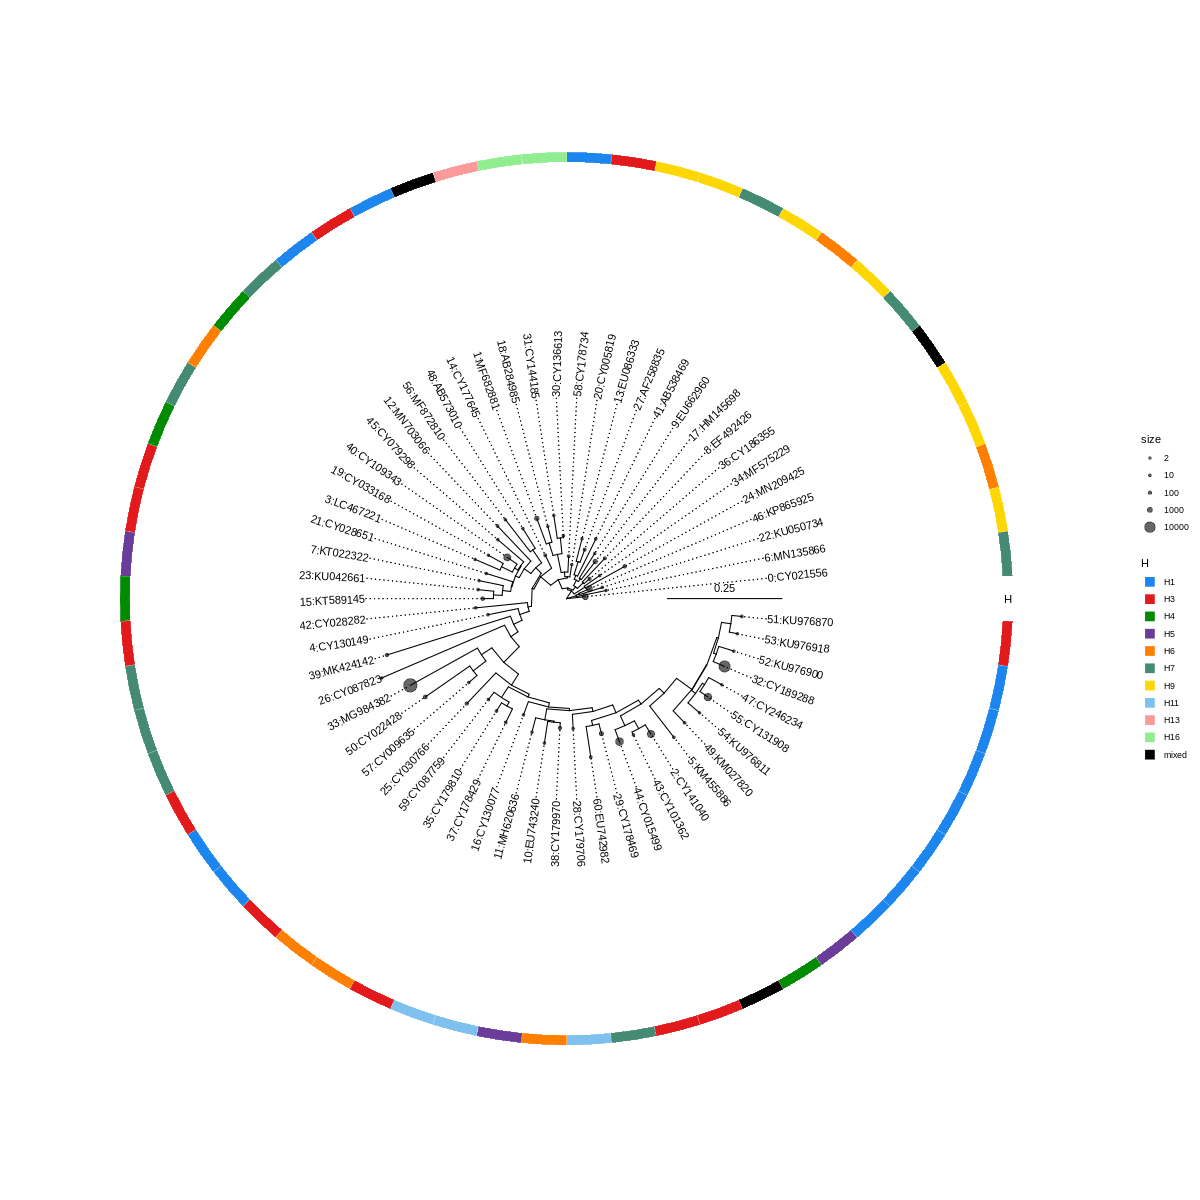

In [48]:
%%R -w 1200 -h 1200
#options(repr.plot.width=20, repr.plot.height=20)

p0 <- ggtree(tree, layout='circular') %<+% centroid

p1 <- open_tree(p0, 0) +
    geom_treescale(width = 0.25) + 
    geom_tippoint(aes(size=size), alpha=.6) +
    geom_tiplab2(aes(label=paste0(cluster, ':', label)), align=TRUE) +#, parse=T) +
    scale_size_continuous(
        name = 'size',
        breaks = c(2, 10, 100, 1000, 10000), 
    )   

if(color != ''){
    p2 <- p1 +
         new_scale_fill()

    p3 <- gheatmap(
            p2,
            frame,
            offset=0.5, 
            width=0.05, 
            #font.size=3, 
            #colnames_angle=0, 
            colnames = TRUE, 
            #hjust=0
        ) +
        {if(color != '')scale_fill_manual(
            name = color,
            values = c(listcolor[0:q], 'black'),
            breaks = subtype, 
            labels = subtype,
            #na.value = "black",
            guide = guide_legend(override.aes = list(shape = 15, size = 5))
        )}
}else{
    p3 <- p1
}

print(p3)
ggsave(paste0(outfolder, 'centroid_', name, '.pdf'), width = 40, height = 40, units = 'cm', limitsize = FALSE)

In [49]:
%%R
msa <- read.dna(paste0(outfolder, 'centroids_', name, '.msa.fasta'), format = 'fasta')
dm <- dist.ml(msa)
nnet <- neighborNet(dm)
#nnet <- read.nexus.networx(paste0('centroids_', name, '.nex'))

In [50]:
%%R
if(color != ''){
    k <- sapply(nnet$tip.label, (\(x) centroid[which(centroid$accession == x),][[color]]), simplify = TRUE, USE.NAMES = TRUE)
}

c <- sapply(nnet$tip.label, (\(x) centroid[which(centroid$accession == x),]$cluster), simplify = TRUE, USE.NAMES = TRUE)
s <- sapply(nnet$tip.label, (\(x) centroid[which(centroid$accession == x),]$size), simplify = TRUE, USE.NAMES = TRUE)

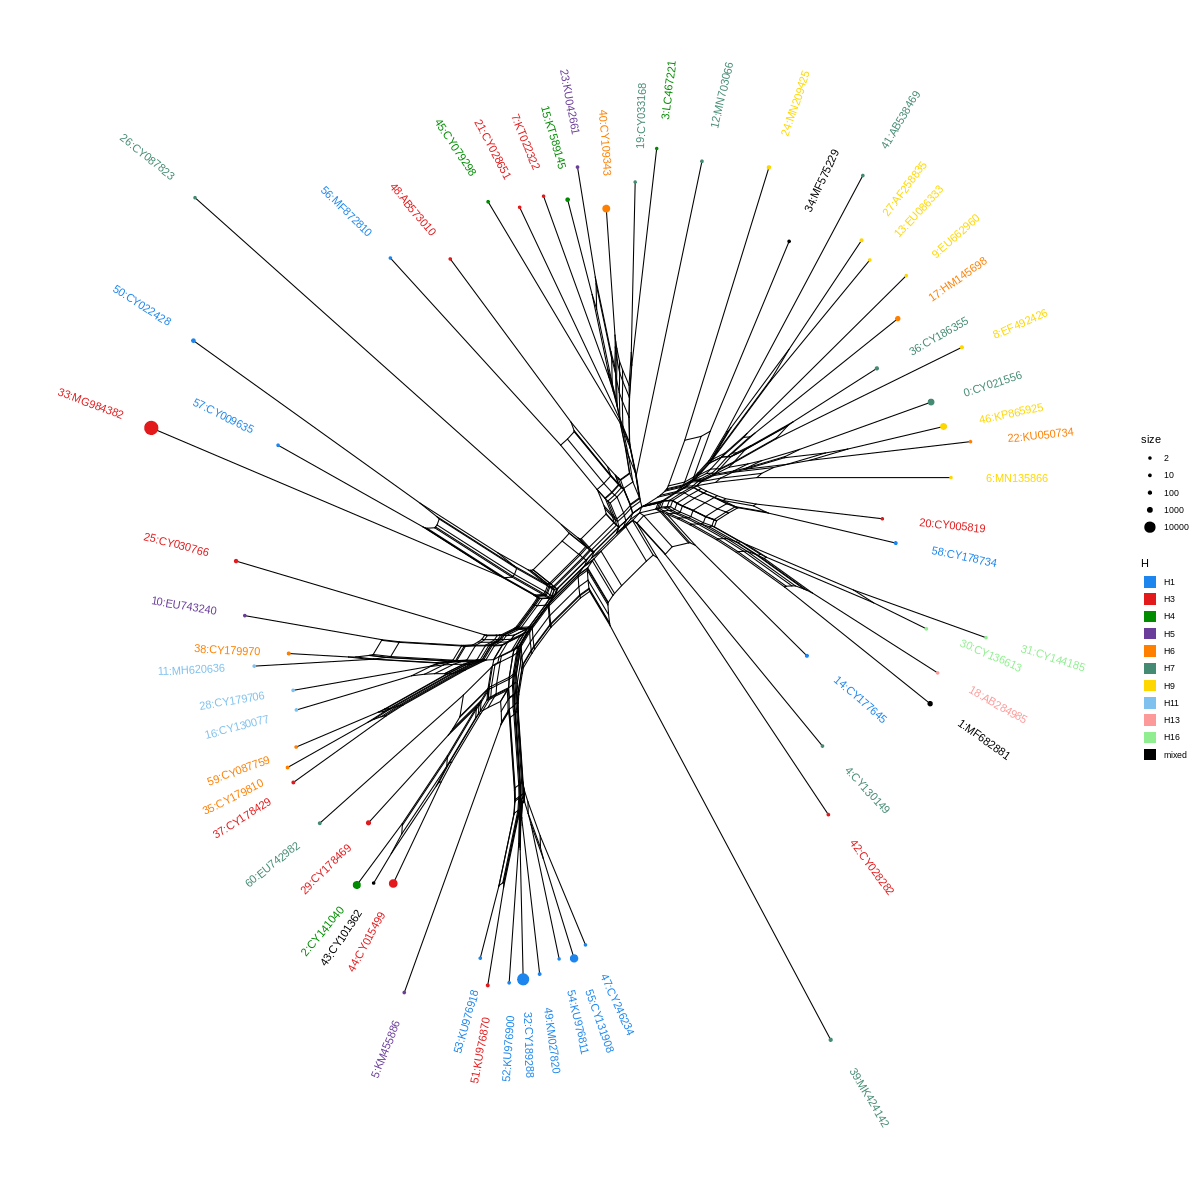

In [51]:
%%R -w 1200 -h 1200
#options(repr.plot.width=20, repr.plot.height=20)

p4 <- ggsplitnet(nnet) 

p5 <- p4 + 
    {if(color != '')geom_tiplab2(aes(label = paste0(c[label], ':', label), color = k[label]), hjust = -.5)} +
    {if(color == '')geom_tiplab2(aes(label = paste0(c[label], ':', label)), hjust = -.5)} +
    {if(color != '')geom_tippoint(aes(color = k[label], size = s[label]))} +
    {if(color == '')geom_tippoint(aes(size = s[label]))} +
    theme(legend.position = 'right') +
    {if(color != '')scale_color_manual(
        name = color,
        values = c(listcolor[0:q], 'black'),
        breaks = subtype, 
        labels = subtype,
        #na.value = "black",
        guide = guide_legend(override.aes = list(shape = 15, size = 5))
    )} +
    scale_size_continuous(
        name = 'size',
        breaks = c(2, 10, 100, 1000, 10000), 
    ) +
    ggexpand(.1) + ggexpand(.1, direction=-1)

print(p5)
ggsave(paste0(outfolder, 'nexus_', name, '.pdf'), width = 40, height = 40, units = 'cm', limitsize = FALSE)